In [1]:
import numpy as np
import matplotlib.pyplot as plt

from alpub_autoencoder.autoencoder_utils import read_alpub_data
from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [4]:
ALPUB_PATH = '../../Datasets/alpub_v2/images'

In [5]:
X,Y = read_alpub_data(path=ALPUB_PATH)

Processing Alpha
Processing Beta
Processing Chi
Processing Delta
Processing Epsilon
Processing Eta
Processing Gamma
Processing Iota
Processing Kappa
Processing Lambda
Processing LunateSigma
Processing Mu
Processing Nu
Processing Omega
Processing Omicron
Processing Phi
Processing Pi
Processing Psi
Processing Rho
Processing Tau
Processing Theta
Processing Upsilon
Processing Xi
Processing Zeta


In [6]:
Y.shape

(205797, 24)

In [7]:
X.shape

(205797, 70, 70, 3)

In [8]:
# Convert the RGB images to grayscale
X_gray = []
for img in X:
    image_gray = Image.fromarray(img).convert("L")
    X_gray.append(np.array(image_gray))

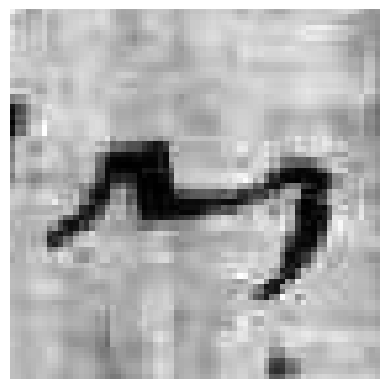

In [9]:
# Display the grayscale image
plt.imshow(X_gray[100000], cmap="gray")
plt.axis("off")
plt.show()

In [10]:
X_in = np.array(X_gray).reshape(len(X_gray), -1)

In [11]:
X_in.shape

(205797, 4900)

In [12]:
# Test-train split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while preserving label balance
X_train, X_test, Y_train, Y_test = train_test_split(X_in, Y, test_size=0.1, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, stratify=Y_train)

In [13]:
print("Train images shape:",X_train.shape)
print("Train labels shape:",Y_train.shape)
print("Test images shape:",X_test.shape)
print("Test labels shape:",Y_test.shape)
print("Validation images shape:",X_val.shape)
print("Validation labels shape:",Y_val.shape)

Train images shape: (166695, 4900)
Train labels shape: (166695, 24)
Test images shape: (20580, 4900)
Test labels shape: (20580, 24)
Validation images shape: (18522, 4900)
Validation labels shape: (18522, 24)


In [14]:
#Autoencoder Implementation

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

In [15]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)

        self.images = self.images.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [17]:
train_dataset = CharacterDataset(X_train, Y_train)
test_dataset = CharacterDataset(X_test, Y_test)
val_dataset = CharacterDataset(X_val, Y_val)

In [18]:
#Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Training model with 2 latent dimensions...
Epoch [1/10], Train Loss: 2768.1054, Test Loss: 1123.9600
Epoch [2/10], Train Loss: 1145.7978, Test Loss: 1109.1332
Epoch [3/10], Train Loss: 1077.6333, Test Loss: 1011.5105
Epoch [4/10], Train Loss: 1027.4188, Test Loss: 1011.8740
Epoch [5/10], Train Loss: 1026.0015, Test Loss: 1006.8572
Epoch [6/10], Train Loss: 1022.5437, Test Loss: 1013.2635
Epoch [7/10], Train Loss: 1021.7982, Test Loss: 1006.7565
Epoch [8/10], Train Loss: 1022.1504, Test Loss: 1006.9100
Epoch [9/10], Train Loss: 1020.3269, Test Loss: 1006.5051
Epoch [10/10], Train Loss: 1020.1900, Test Loss: 1006.6276


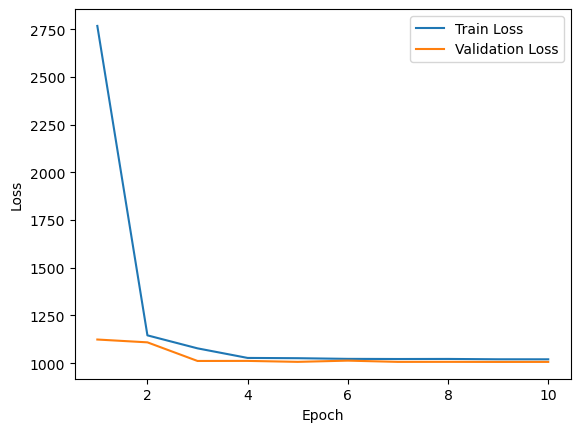

Training model with 5 latent dimensions...
Epoch [1/10], Train Loss: 2085.9305, Test Loss: 1164.2549
Epoch [2/10], Train Loss: 1086.8631, Test Loss: 955.6786
Epoch [3/10], Train Loss: 869.9853, Test Loss: 845.3244
Epoch [4/10], Train Loss: 818.0056, Test Loss: 818.1720
Epoch [5/10], Train Loss: 813.1950, Test Loss: 799.5861
Epoch [6/10], Train Loss: 813.4916, Test Loss: 845.8239
Epoch [7/10], Train Loss: 810.8281, Test Loss: 865.6139
Epoch [8/10], Train Loss: 810.8220, Test Loss: 800.7348
Epoch [9/10], Train Loss: 809.7274, Test Loss: 798.2987
Epoch [10/10], Train Loss: 809.4139, Test Loss: 798.5855


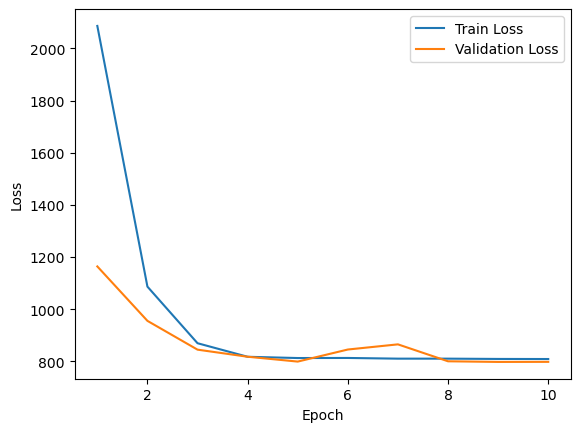

Training model with 10 latent dimensions...
Epoch [1/10], Train Loss: 1813.5072, Test Loss: 1094.6576
Epoch [2/10], Train Loss: 890.7383, Test Loss: 750.5962
Epoch [3/10], Train Loss: 684.4961, Test Loss: 634.6118
Epoch [4/10], Train Loss: 645.5778, Test Loss: 684.4368
Epoch [5/10], Train Loss: 640.4111, Test Loss: 653.4613
Epoch [6/10], Train Loss: 639.3816, Test Loss: 646.7660
Epoch [7/10], Train Loss: 637.2625, Test Loss: 657.4810
Epoch [8/10], Train Loss: 637.7211, Test Loss: 626.0814
Epoch [9/10], Train Loss: 635.4965, Test Loss: 651.7419
Epoch [10/10], Train Loss: 635.1643, Test Loss: 627.7570


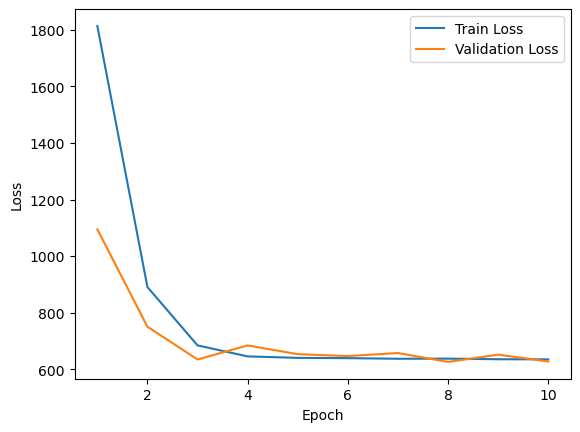

Training model with 25 latent dimensions...
Epoch [1/10], Train Loss: 1283.8934, Test Loss: 717.6391
Epoch [2/10], Train Loss: 582.6881, Test Loss: 448.1210
Epoch [3/10], Train Loss: 432.6344, Test Loss: 392.7813
Epoch [4/10], Train Loss: 408.5497, Test Loss: 412.9418
Epoch [5/10], Train Loss: 404.1734, Test Loss: 394.2782
Epoch [6/10], Train Loss: 402.4405, Test Loss: 396.2527
Epoch [7/10], Train Loss: 401.7463, Test Loss: 393.3359
Epoch [8/10], Train Loss: 401.1376, Test Loss: 392.8686
Epoch [9/10], Train Loss: 401.3936, Test Loss: 393.5650
Epoch [10/10], Train Loss: 400.5972, Test Loss: 410.2405


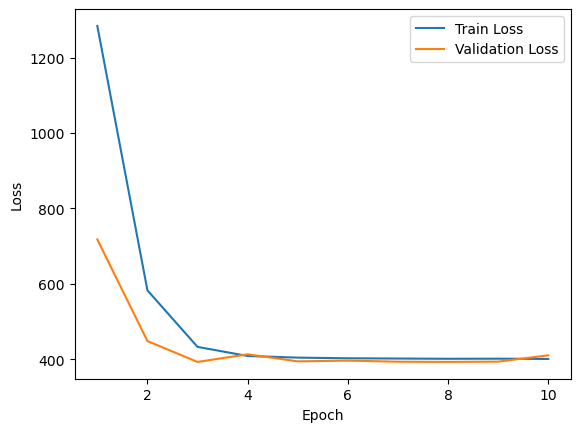

Training model with 50 latent dimensions...
Epoch [1/10], Train Loss: 1022.3208, Test Loss: 504.8558
Epoch [2/10], Train Loss: 418.6834, Test Loss: 339.4997
Epoch [3/10], Train Loss: 302.2113, Test Loss: 315.6216
Epoch [4/10], Train Loss: 272.1963, Test Loss: 288.9985
Epoch [5/10], Train Loss: 263.9063, Test Loss: 293.3322
Epoch [6/10], Train Loss: 262.5865, Test Loss: 256.9216
Epoch [7/10], Train Loss: 261.4385, Test Loss: 260.6530
Epoch [8/10], Train Loss: 260.6987, Test Loss: 306.8979
Epoch [9/10], Train Loss: 259.4701, Test Loss: 254.6854
Epoch [10/10], Train Loss: 259.5685, Test Loss: 254.8141


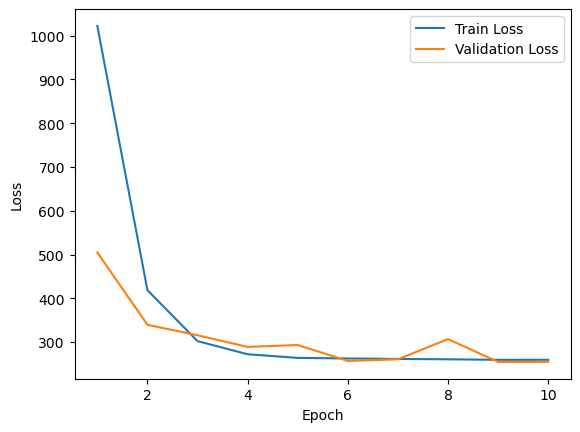

Training model with 100 latent dimensions...
Epoch [1/10], Train Loss: 768.1648, Test Loss: 357.1490
Epoch [2/10], Train Loss: 305.7994, Test Loss: 227.5594
Epoch [3/10], Train Loss: 199.2209, Test Loss: 174.1101
Epoch [4/10], Train Loss: 494.2898, Test Loss: 169.4193
Epoch [5/10], Train Loss: 161.3738, Test Loss: 153.7218
Epoch [6/10], Train Loss: 161.1892, Test Loss: 149.6583
Epoch [7/10], Train Loss: 289.2595, Test Loss: 151.2491
Epoch [8/10], Train Loss: 154.1796, Test Loss: 147.3329
Epoch [9/10], Train Loss: 274.0136, Test Loss: 168.8073
Epoch [10/10], Train Loss: 155.4741, Test Loss: 156.3270


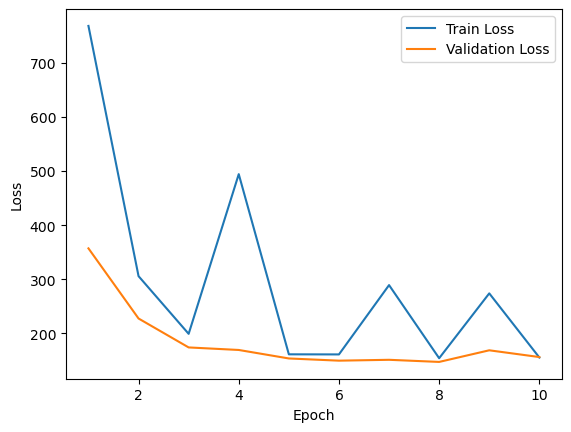

Training model with 500 latent dimensions...
Epoch [1/10], Train Loss: 2104.6724, Test Loss: 176.8661
Epoch [2/10], Train Loss: 176.9741, Test Loss: 156.6243
Epoch [3/10], Train Loss: 137.1151, Test Loss: 121.2919
Epoch [4/10], Train Loss: 4898.9869, Test Loss: 119.2897
Epoch [5/10], Train Loss: 179.8131, Test Loss: 91.6206
Epoch [6/10], Train Loss: 110.1124, Test Loss: 89.1567
Epoch [7/10], Train Loss: 115.4350, Test Loss: 168.3236
Epoch [8/10], Train Loss: 3065.6690, Test Loss: 145.1415
Epoch [9/10], Train Loss: 129.7883, Test Loss: 70.2606
Epoch [10/10], Train Loss: 81.0157, Test Loss: 68.1495


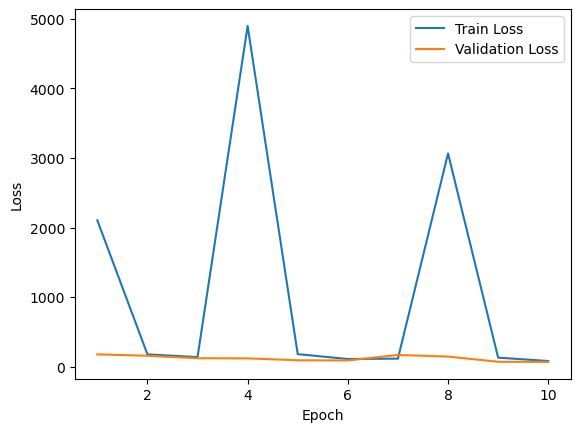

In [29]:
for latent_dim in [2,5,10,25,50,100,500]: # train for [2,5,10,20,100] latent dims

    print("Training model with", latent_dim,"latent dimensions...")

    input_dim = 4900  # Dimensionality of the input data

    model = Autoencoder(input_dim, latent_dim)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    batch_size = 64
    best_test_loss = float('inf')
    best_model_state = None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0

        # Training
        model.train()
        for batch in train_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch

                # Forward pass
                reconstructions = model(images)
                loss = criterion(reconstructions, images)

                test_loss += loss.item() * images.size(0)

            test_loss /= len(val_loader.dataset)
            test_losses.append(test_loss)

            # Check if current model has the lowest test loss so far
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_state = model.state_dict().copy()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Plotting train and test loss
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Load the best model state (lowest test loss)
    model.load_state_dict(best_model_state)
    torch.save(model, '../models/alpub_autoencoder_dim_'+str(latent_dim)+'.pt')

Test results for latent dim 2 ...


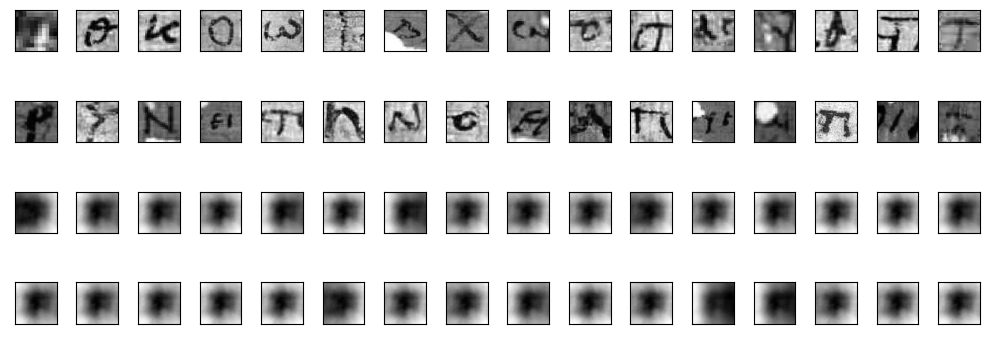

Test results for latent dim 5 ...


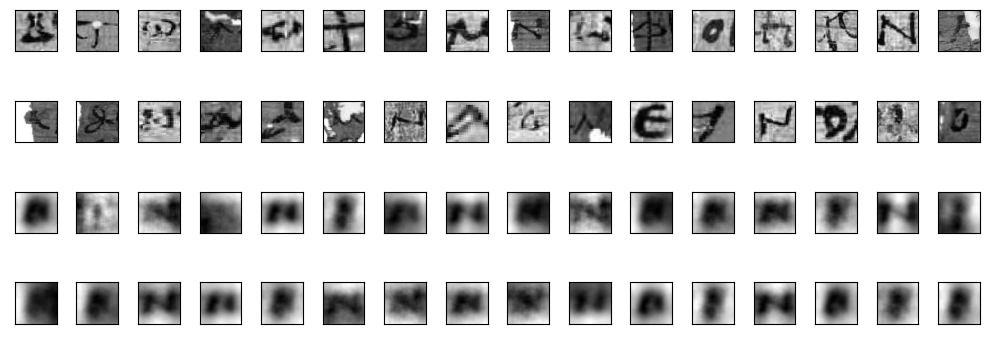

Test results for latent dim 10 ...


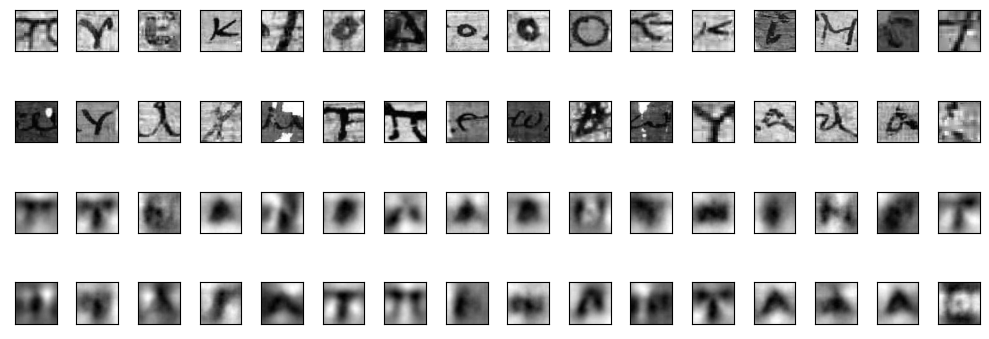

Test results for latent dim 25 ...


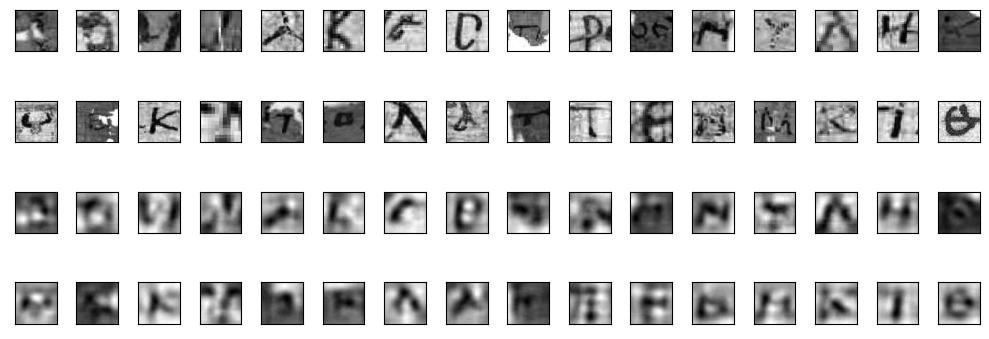

Test results for latent dim 50 ...


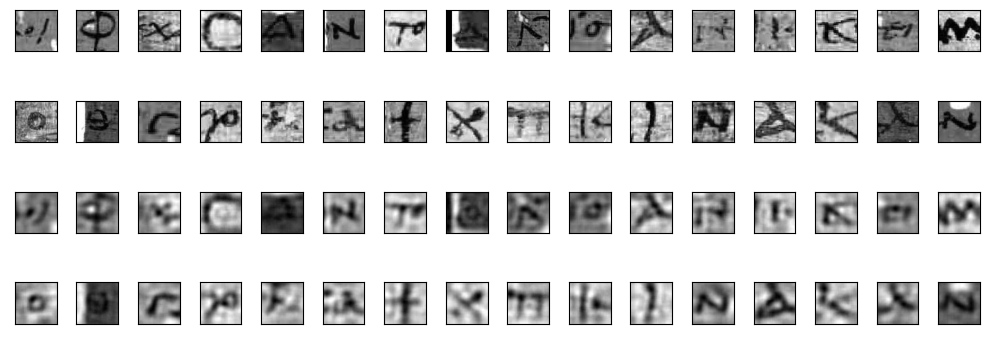

Test results for latent dim 100 ...


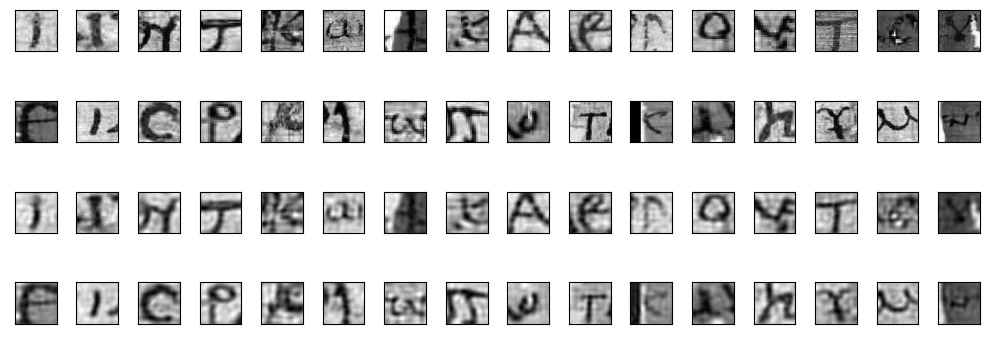

Test results for latent dim 500 ...


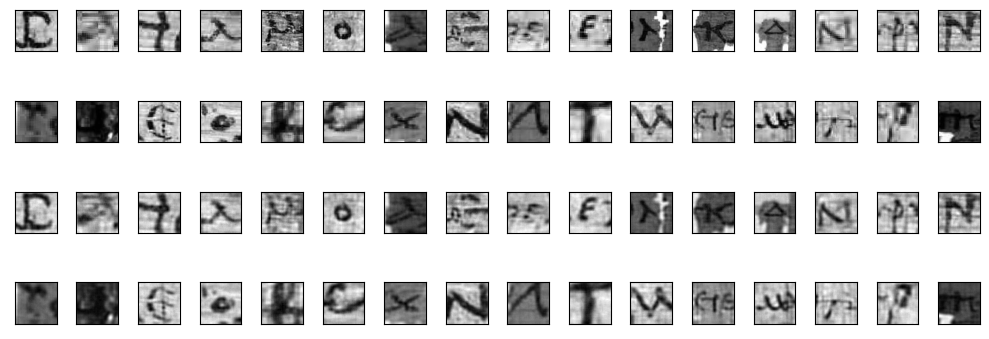

In [39]:
for latent_dim in [2,5,10,25,50,100,500]: # evaluate for [2,5,10,20,100] latent dims

    print('Test results for latent dim', latent_dim, '...')

    model = torch.load('../models/alpub_autoencoder_dim_'+str(latent_dim)+'.pt')
    # Set the model to evaluation mode
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Get a batch of test data
    test_batch = next(iter(test_loader))
    test_images, _ = test_batch

    # Pass the test data through the model
    with torch.no_grad():
        reconstructions = model(test_images)

    # Plot the original images and their reconstructions
    fig, axes = plt.subplots(nrows=4, ncols=batch_size // 4, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        if i < batch_size // 2:
            # Plot original image
            ax.imshow(test_images[i].cpu().numpy().reshape(70, 70), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        else:
            # Plot reconstructed image
            ax.imshow(reconstructions[i - batch_size // 2].cpu().numpy().reshape(70, 70), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])


    plt.tight_layout()
    plt.show()